In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import chess
import  numpy as np
import board_util

2024-03-14 00:04:03.642337: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-14 00:04:03.681601: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 00:04:03.681627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 00:04:03.682783: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-14 00:04:03.688663: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-14 00:04:03.689389: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [14]:
num_possible_moves = 64  # Number of possible moves

# CNN model
model = models.Sequential([
    tf.keras.Input(shape=(12, 8, 8)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),  # Change the number of units to 64
  
    # Output layer for the entire move
    tf.keras.layers.Dense(num_possible_moves, activation='softmax'),
    # Output layer for five units
    tf.keras.layers.Dense(5, activation='softmax', name='output_move')
])


# Compile the model with appropriate loss and metrics
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 10, 6, 32)         2336      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 3, 32)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 480)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                30784     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 output_move (Dense)         (None, 5)                 325       
                                                      

In [17]:
# Read in data
file_path = "dataset_fen.txt"
data = []
with open(file_path, "r") as file:
    lines = file.readlines()

for line in lines:
    chessboard_state, move = line.split("[MOVESEP]")
    cb = chess.Board(chessboard_state)
    bb = board_util.board_to_bitboards(cb)
    ab = board_util.bitboards_to_array(bb)
   
    encoded_move = board_util.encode_move(move.strip(), ab)
    data.append((ab, encoded_move))

    

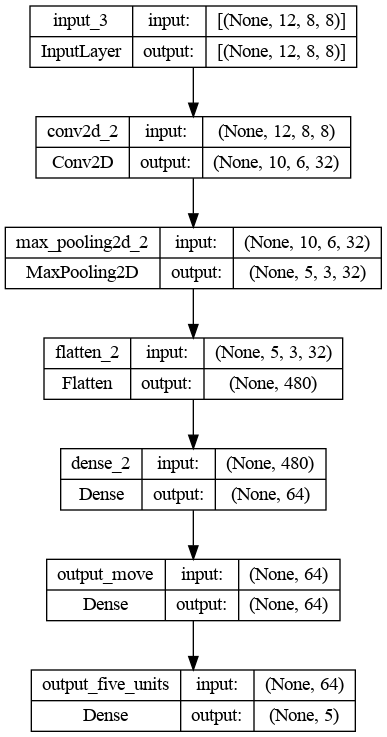

In [12]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot_output_move.png', show_shapes=True, show_layer_names=True)

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import train_test_split


In [18]:


board = [item[0] for item in data]
move = [item[1] for item in data]

x_train, x_test, y_train, y_test = train_test_split(board, move, test_size=0.3, random_state=42)

# Convert lists to numpy arrays
x_train = np.array(x_train)
x_test = np.array(x_test)

# Convert moves to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# No need for one-hot encoding for the moves, as they are already encoded

 


checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


In [20]:
epochs = 20
batch_size = 64

history = model.fit(
    x_train,
    {'output_move': y_train},
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, {'output_move': y_test}),
    callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback, reduce_lr_callback]
)

Epoch 1/20
4279/4279 [==============================] - 16s 4ms/step - loss: 19.8819 - accuracy: 0.3781 - val_loss: 19.8966 - val_accuracy: 0.3782 - lr: 2.0000e-04
Epoch 2/20
4279/4279 [==============================] - 17s 4ms/step - loss: 19.8910 - accuracy: 0.3781 - val_loss: 19.9056 - val_accuracy: 0.3782 - lr: 2.0000e-04
Epoch 3/20
4279/4279 [==============================] - 19s 4ms/step - loss: 19.9002 - accuracy: 0.3781 - val_loss: 19.9151 - val_accuracy: 0.3782 - lr: 2.0000e-04
Epoch 4/20
4279/4279 [==============================] - 19s 4ms/step - loss: 19.9096 - accuracy: 0.3781 - val_loss: 19.9246 - val_accuracy: 0.3782 - lr: 2.0000e-04
Epoch 5/20
4279/4279 [==============================] - 18s 4ms/step - loss: 19.9155 - accuracy: 0.3781 - val_loss: 19.9265 - val_accuracy: 0.3782 - lr: 4.0000e-05
Epoch 6/20
4279/4279 [==============================] - 17s 4ms/step - loss: 19.9173 - accuracy: 0.3781 - val_loss: 19.9283 - val_accuracy: 0.3782 - lr: 4.0000e-05
